In [1]:
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qutip import *

from project_config.paths import FIGURES_TESTS_DIR
name_plot_folder = "test_N_atoms_geometry"
custom_dir = FIGURES_TESTS_DIR / name_plot_folder

from plotstyle import COLORS, MARKERS, LINE_STYLES, FONT_SIZE, LATEX_DOC_WIDTH, set_size, save_fig, latex_available, format_sci_notation, init_style
init_style()

In [2]:
# Test and visualize Gaussian inhomogeneity sampling
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

from qspectro2d.spectroscopy.inhomogenity import normalized_gauss, sample_from_gaussian, _fwhm_to_sigma

def plot_gaussian_check(
    mu: float,
    fwhm: float,
    *,
    n_samples: int = 100_000,
    max_detuning: float = 10.0,
    bins: int = 200,
    ax: Optional[plt.Axes] = None,
    color: str = "C0",
    ls: str = "solid",
) -> Tuple[float, float]:
    """Draw samples and overlay with theoretical normalized Gaussian.

    Returns (sample_mean, sample_std).
    """
    # Sample
    samples      = sample_from_gaussian(n_samples, fwhm, mu, max_detuning=max_detuning)
    samples      = np.asarray(samples, dtype=float).ravel()

    # Stats
    mu_hat       = float(np.mean(samples))
    std_hat      = float(np.std(samples, ddof=1))
    sigma_theory = _fwhm_to_sigma(fwhm)

    # X-grid for theory
    half_width   = max_detuning * fwhm
    x_min        = mu - half_width
    x_max        = mu + half_width
    x            = np.linspace(x_min, x_max, 1000)
    y            = normalized_gauss(x, fwhm=fwhm, mu=mu)

    # Plot
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4.5))
    ax.hist(
        samples,
        bins=bins,
        range=(x_min, x_max),
        density=True,
        color=color,
        histtype="step",
        linewidth=1.5,
        label=rf"samples ($n={n_samples}$)"
    )
    ax.plot(
        x,
        y,
        color=color,
        linestyle=ls,
        linewidth=2.0,
        label=rf"theory $\mathcal{{N}}(\mu={mu:.1f},\,\mathrm{{FWHM}}={fwhm:.1f})$"
    )

    # Labels
    ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
    ax.set_ylabel(r"Probability density")
    ax.set_title(
        rf"Gaussian samples vs. theory — $\mu={mu:.1f}$, FWHM={fwhm:.1f}, $\sigma_\mathrm{{th}}={sigma_theory:.2f}$; "
        rf"$\bar x={mu_hat:.2f}$, $s={std_hat:.2f}$"
    )
    ax.legend()

    return mu_hat, std_hat

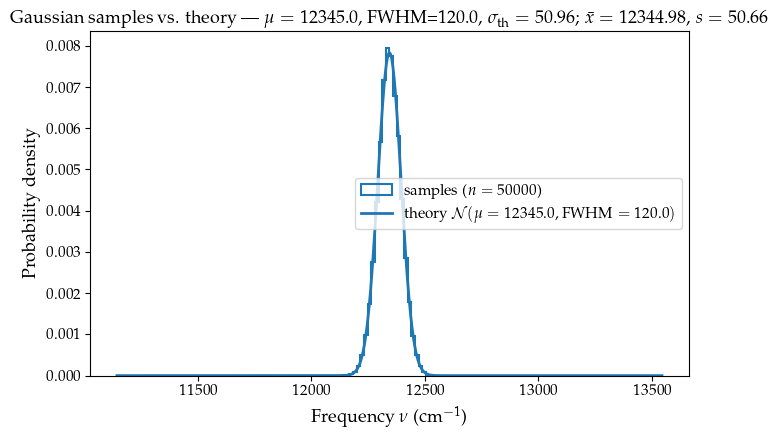

Samples shape (n_samples, n_centers): (20000, 4)
Means per center: [12100.02 12300.15 12499.28 12699.89]
Stds  per center: [42.65 42.58 42.6  42.56]


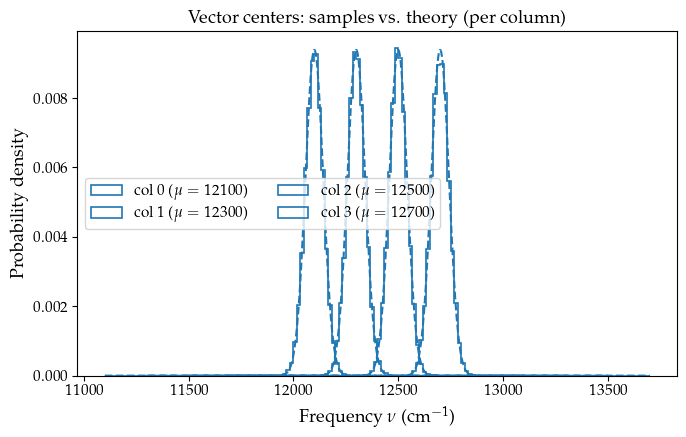

In [3]:
# Run a few visual checks for scalar and vector centers

# Scalar center
mu_scalar   = 12_345.0  # cm^-1
fwhm_scalar = 120.0     # cm^-1
_ = plot_gaussian_check(mu_scalar, fwhm_scalar, n_samples=50_000, bins=150)
plt.tight_layout()
plt.show()

# Vector centers (multiple atoms); check shape and per-column stats
centers = np.array([12_100.0, 12_300.0, 12_500.0, 12_700.0])
fwhm    = 100.0
ns      = 20_000
samples = sample_from_gaussian(ns, fwhm, centers)
print("Samples shape (n_samples, n_centers):", samples.shape)

means = samples.mean(axis=0)
stds  = samples.std(axis=0, ddof=1)
print("Means per center:", np.round(means, 2))
print("Stds  per center:", np.round(stds, 2))

# Overlay histograms for a couple of columns
fig, ax = plt.subplots(figsize=(7, 4.5))
colors = ["C0", "C1", "C2", "C3"]
for i, c in enumerate(centers):
    x   = np.linspace(c - 10*fwhm, c + 10*fwhm, 600)
    ax.hist(samples[:, i], bins=120, range=(c - 10*fwhm, c + 10*fwhm), density=True,
            histtype="step", color=colors[i], linewidth=1.2, label=rf"col {i} ($\mu={c:.0f}$)")
    ax.plot(x, normalized_gauss(x, fwhm=fwhm, mu=c), color=colors[i], linestyle="dashed")

ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
ax.set_ylabel(r"Probability density")
ax.set_title(r"Vector centers: samples vs. theory (per column)")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

In [4]:
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian
import numpy as np

base = np.array([12100.0, 12300.0, 12500.0])
delta = 100.0
ns    = 10_000

S = sample_from_gaussian(ns, delta, base)
print(S.shape)                  # (10000, 3)
print(np.round(S.mean(0), 1))   # close to base
print(np.round(S.std(0), 1))    # ~ delta/(2*sqrt(2*ln2))

(10000, 3)
[12099.7 12300.4 12499.8]
[43.  42.5 42.2]
